# 0. Setup Paths

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [ ]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
!pip install --upgrade pip
!pip install --upgrade wheel
!pip install --upgrade setuptools
!pip install --upgrade requests

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip install tensorflow==2.9.0 tensorflow-gpu==2.9.0 --upgrade

In [ ]:
!pip install protobuf matplotlib==3.2

In [ ]:
import object_detection

In [ ]:
!pip list

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 2. Create Label Map

In [ ]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [ ]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

# 4. Copy Model Config to Training Folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Update Config For Transfer Learning

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
config

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
!pip uninstall pycocotools -y
!Pip install pycocotools

# 7. Evaluate the Model

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 8. Load Train Model From Checkpoint

In [6]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [7]:
# Prevent GPU complete consumption
# Do this for multiple GPUs if that's the case
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)

In [8]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [9]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [11]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'Cars425.png')

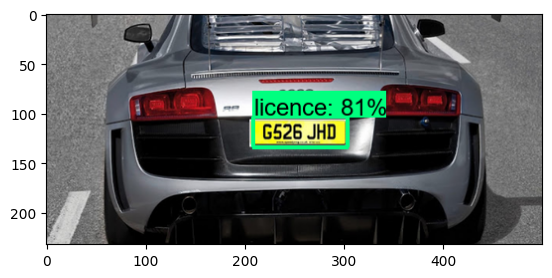

In [12]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
!pip install opencv-python
!pip install opencv-contrib-python
!pip install opencv-python-headless

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/fb/c4/f574ba6f04e6d7bf8c38d23e7a52389566dd7631fee0bcdd79ea07ef2dbf/opencv_python-4.8.0.76-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python-4.8.0.76-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.8.0.76-cp37-abi3-win_amd64.whl (38.1 MB)


  Obtaining dependency information for opencv-contrib-python from https://files.pythonhosted.org/packages/05/33/5a6436146bda09c69decc456cfb54f41d52fbcf558fe91e6df7bdde6cce0/opencv_contrib_python-4.8.0.76-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_contrib_python-4.8.0.76-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.8.0.76-cp37-abi3-win_amd64.whl (44.8 MB)


  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/70/78/7a13730745684584db53e8aa3c3bd84beef2dcb32bebf627bda0d6df461e/opencv_python_headless-4.8.0.76-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python_headless-4.8.0.76-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.8.0.76-cp37-abi3-win_amd64.whl (38.0 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.13.1 requires google-api-python-client>=1.6.7, which is not installed.
tf-models-official 2.13.1 requires immutabledict, which is not installed.
tf-models-official 2.13.1 requires kaggle>=1.3.9, which is not installed.
tf-models-official 2.13.1 requires oauth2client, which is not installed.
tf-models-official 2.13.1 requires py-cpuinfo>=3.3.0, which is not installed.
tf-models-official 2.13.1 requires sentencepiece, which is not installed.
tf-models-official 2.13.1 requires seqeval, which is not installed.
tf-models-official 2.13.1 requires tensorflow-datasets, which is not installed.
tf-models-official 2.13.1 requires tensorflow-hub>=0.6.0, which is not installed.
tf-models-official 2.13.1 requires tensorflow-model-optimization>=0.4.1, which is not installed.
tf-models-official 2.13.1 require

# Apply OCR to Detection

In [13]:
!pip install easyocr

In [14]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118Note: you may need to restart the kernel to use updated packages.


In [13]:
import easyocr

In [14]:
detection_threshold = 0.7

In [15]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [16]:
width = image.shape[1]
height = image.shape[0]

In [21]:
!pip uninstall Pillow -y
!pip install Pillow==9.5.0

Found existing installation: Pillow 9.5.0
Uninstalling Pillow-9.5.0:
  Successfully uninstalled Pillow-9.5.0


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\ZAFER\Documents\GitHub Repositories\License Plate Detection\ANPR\anprsys\lib\site-packages\pip\_internal\cli\base_command.py", line 180, in exc_logging_wrapper
    status = run_func(*args)
  File "C:\Users\ZAFER\Documents\GitHub Repositories\License Plate Detection\ANPR\anprsys\lib\site-packages\pip\_internal\commands\uninstall.py", line 110, in run
    uninstall_pathset.commit()
  File "C:\Users\ZAFER\Documents\GitHub Repositories\License Plate Detection\ANPR\anprsys\lib\site-packages\pip\_internal\req\req_uninstall.py", line 432, in commit
    self._moved_paths.commit()
  File "C:\Users\ZAFER\Documents\GitHub Repositories\License Plate Detection\ANPR\anprsys\lib\site-packages\pip\_internal\req\req_uninstall.py", line 278, in commit
    save_dir.cleanup()
  File "C:\Users\ZAFER\Documents\GitHub Repositories\License Plate Detection\ANPR\anprsys\lib\site-packages\pip\_internal\utils\temp_dir.py", line 173, in cleanup


  Using cached Pillow-9.5.0-cp310-cp310-win_amd64.whl (2.5 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.13.1 requires google-api-python-client>=1.6.7, which is not installed.
tf-models-official 2.13.1 requires immutabledict, which is not installed.
tf-models-official 2.13.1 requires kaggle>=1.3.9, which is not installed.
tf-models-official 2.13.1 requires oauth2client, which is not installed.
tf-models-official 2.13.1 requires py-cpuinfo>=3.3.0, which is not installed.
tf-models-official 2.13.1 requires sentencepiece, which is not installed.
tf-models-official 2.13.1 requires seqeval, which is not installed.
tf-models-official 2.13.1 requires tensorflow-datasets, which is not installed.
tf-models-official 2.13.1 requires tensorflow-hub>=0.6.0, which is not installed.
tf-models-official 2.13.1 requires tensorflow-model-optimization>=0.4.1, which is not installed.
tf-models-official 2.13.1 require

[0.45178494 0.41629902 0.58157873 0.60918486]
[104.81410575 208.14950764 134.92626572 304.59243059]
[([[6, 4], [88, 4], [88, 28], [6, 28]], '6526 JHD', 0.9107108485471753)]


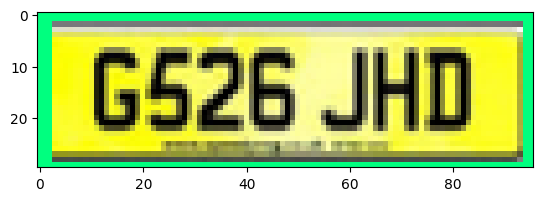

In [17]:
# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    print(box)
    roi = box*[height, width, height, width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

In [18]:
for result in ocr_result:
    print(np.sum(np.subtract(result[0][2],result[0][1])))
    print(result[1])

24
6526 JHD


# OCR Filtering

In [21]:
region_threshold = 0.05

In [22]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [23]:
filter_text(region, ocr_result, region_threshold)

['6526 JHD']

# Bring it Together

In [24]:
region_threshold = 0.6

In [25]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text, region

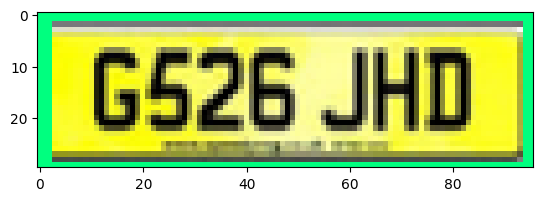

['6526 JHD']


In [26]:
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

# 10. Real Time Detections from your Webcam

In [27]:
!pip uninstall opencv-python-headless -y

Found existing installation: opencv-python-headless 4.8.0.76
Uninstalling opencv-python-headless-4.8.0.76:
  Successfully uninstalled opencv-python-headless-4.8.0.76


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\ZAFER\Documents\GitHub Repositories\License Plate Detection\ANPR\anprsys\lib\site-packages\pip\_internal\cli\base_command.py", line 180, in exc_logging_wrapper
    status = run_func(*args)
  File "C:\Users\ZAFER\Documents\GitHub Repositories\License Plate Detection\ANPR\anprsys\lib\site-packages\pip\_internal\commands\uninstall.py", line 110, in run
    uninstall_pathset.commit()
  File "C:\Users\ZAFER\Documents\GitHub Repositories\License Plate Detection\ANPR\anprsys\lib\site-packages\pip\_internal\req\req_uninstall.py", line 432, in commit
    self._moved_paths.commit()
  File "C:\Users\ZAFER\Documents\GitHub Repositories\License Plate Detection\ANPR\anprsys\lib\site-packages\pip\_internal\req\req_uninstall.py", line 278, in commit
    save_dir.cleanup()
  File "C:\Users\ZAFER\Documents\GitHub Repositories\License Plate Detection\ANPR\anprsys\lib\site-packages\pip\_internal\utils\temp_dir.py", line 173, in cleanup


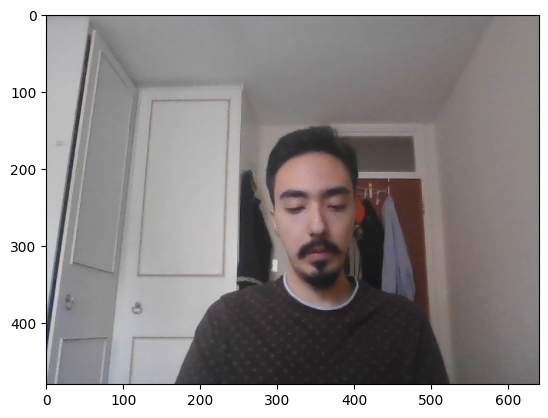

[]


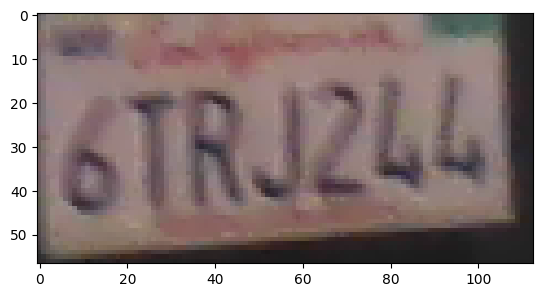

['6TR444']


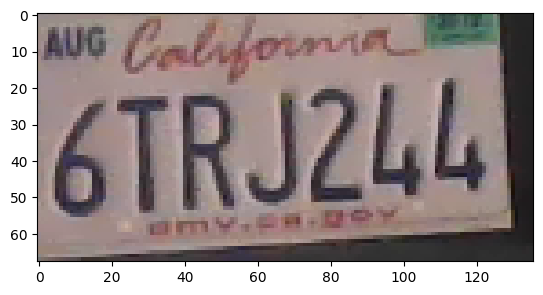

['6TRJZLL']


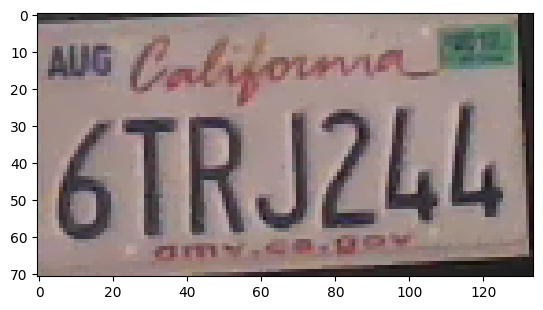

['GTRJZLL]']


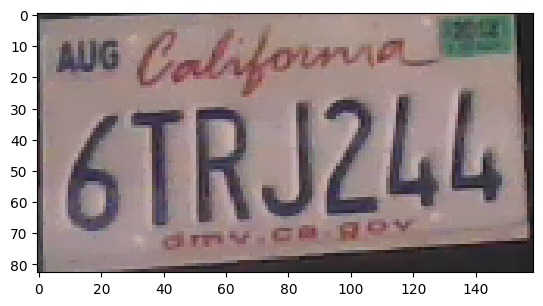

['GTRJZLL']


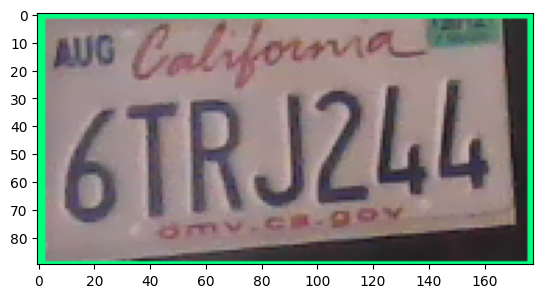

['GTRJZLL]']


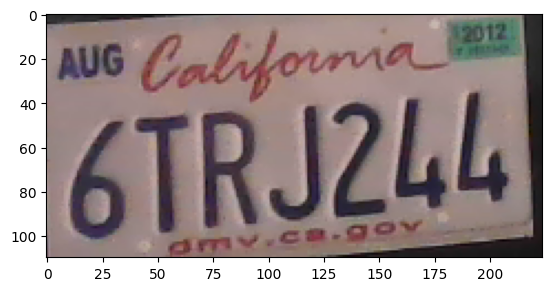

['GTRJZLL']


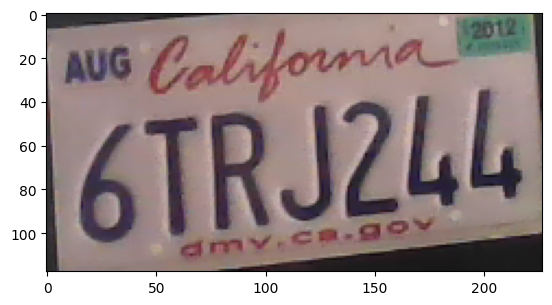

['GTRJZLL']


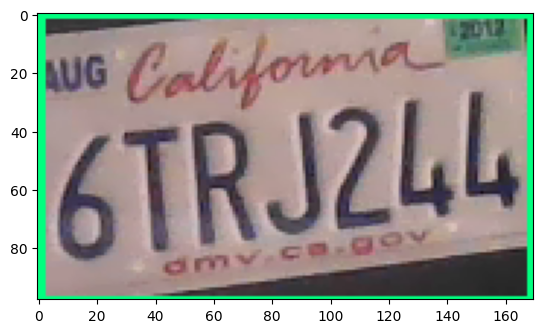

['GTRJZLL']


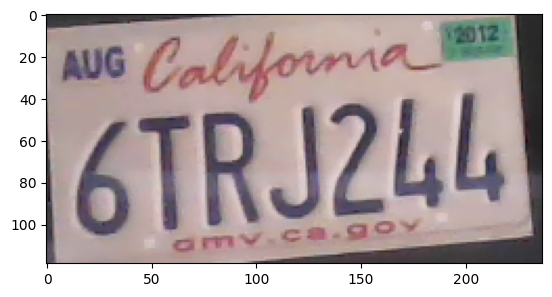

['GTRJZLL']


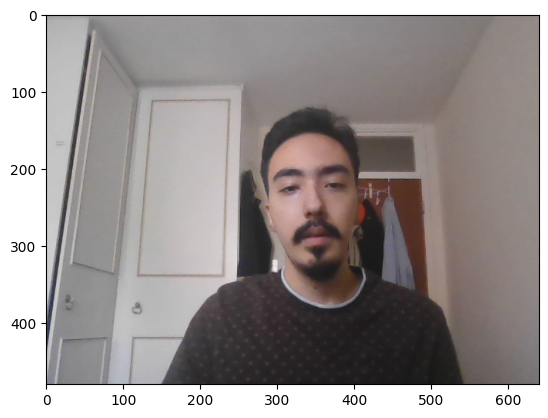

[]


In [28]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    try: 
        text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
        save_results(text, region, 'realtimeresults.csv', 'Detection_Images')
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

In [34]:
!pip list

Package                      Version             Editable project location
---------------------------- ------------------- ---------------------------------------------------------------------------------------------------------
absl-py                      1.4.0
anyio                        3.7.1
apache-beam                  2.50.0rc1
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
avro-python3                 1.10.2
Babel                        2.12.1
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
cachetools                   5.3.1
certifi                      2023.7.22
cffi                         1.15.1
charset-normalizer           3.2.0
colorama                     0.4.6
comm                         0.1.4
contextlib2         

# Save Results

In [29]:
import csv
import uuid

In [30]:
'{}.jpg'.format(uuid.uuid1())

'35c15381-435d-11ee-b404-18cc188d84ab.jpg'

In [31]:
def save_results(text, region, csv_filename, folder_path):
    img_name = '{}.jpg'.format(uuid.uuid1())
    
    cv2.imwrite(os.path.join(folder_path, img_name), region)
    
    with open(csv_filename, mode='a', newline='') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name, text])

In [32]:
region

array([[[164, 165, 163],
        [164, 165, 163],
        [166, 164, 164],
        ...,
        [133, 139, 147],
        [133, 139, 147],
        [133, 139, 147]],

       [[164, 165, 163],
        [164, 165, 163],
        [166, 164, 164],
        ...,
        [133, 139, 147],
        [133, 139, 147],
        [133, 139, 147]],

       [[166, 164, 164],
        [166, 164, 164],
        [164, 164, 164],
        ...,
        [137, 138, 147],
        [137, 138, 147],
        [137, 138, 147]],

       ...,

       [[185, 189, 177],
        [136, 140, 128],
        [147, 139, 134],
        ...,
        [114, 115, 120],
        [114, 115, 120],
        [116, 116, 121]],

       [[191, 184, 176],
        [145, 139, 131],
        [145, 137, 134],
        ...,
        [114, 115, 120],
        [116, 116, 118],
        [116, 116, 118]],

       [[188, 182, 174],
        [145, 139, 131],
        [145, 137, 134],
        ...,
        [114, 115, 120],
        [116, 116, 118],
        [116, 116, 118]]

In [33]:
save_results(text, region, 'detection_results.csv', 'Detection_Images')

# 10. Freezing the Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 11. Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
!{command}

# 13. Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')